In [1]:
import numpy as np
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd
import ipywidgets as widgets
from IPython.html.widgets import *
import pickle
import h5py 
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import keras
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Activation, Dropout, Flatten, Dense, Lambda
from keras.layers import ELU
from keras.optimizers import Adam
import keras.backend.tensorflow_backend as KTF



%matplotlib inline

/usr/local/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
Using TensorFlow backend.


In [2]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [3]:
# constants
DATA_PATH = '/speed_challenge-2017/data'
TRAIN_VIDEO = os.path.join(DATA_PATH, 'train.mp4') #'drive.mp4' 'train.mp4'
TEST_VIDEO = os.path.join(DATA_PATH, 'test.mp4')
CLEAN_DATA_PATH = '/speed_challenge_2017/clean_data'
CLEAN_IMGS_TRAIN = os.path.join(CLEAN_DATA_PATH, 'train_imgs') #train2_imgs train_imgs
CLEAN_IMGS_TEST = os.path.join(CLEAN_DATA_PATH, 'test_imgs')
ASSETS_PATH = '/speed_challenge_2017/assets'

train_frames = 8616 #20400 #8616
test_frames = 10798

seeds = [1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144]


# hyperparameters
batch_size = 16
num_epochs = 25 #100 #90 
steps_per_epoch = 800

# run specific constants
model_name = 'nvidia' #nvidia2
run_name = 'model={}-batch_size={}-num_epoch={}-steps_per_epoch={}'.format(model_name,
                                                                          batch_size,
                                                                          num_epochs,
                                                                          steps_per_epoch)

assets_filepath = os.path.join(ASSETS_PATH, 'model_assets' , run_name)
weights_loc = os.path.join(assets_filepath,'weights.h5')
history_loc=  os.path.join(assets_filepath,'history.p')
tensorboard_loc = os.path.join(assets_filepath, run_name)



In [4]:
run_name

'model=nvidia-batch_size=16-num_epoch=25-steps_per_epoch=800'

In [5]:
train_meta = pd.read_csv(os.path.join(CLEAN_DATA_PATH, 'train_meta.csv')) #train2_meta
print('shape: ', train_meta.shape)

shape:  (20400, 3)


## Jovsa's Split

In [6]:
# note: there is a chance that points might appear again. as n

def train_valid_split(dframe, seed_val):
    """
    Randomly shuffle pairs of rows in the dataframe, separates train and validation data
    generates a uniform random variable 0->9, gives 20% chance to append to valid data, otherwise train_data
    return tuple (train_data, valid_data) dataframes
    """
    train_data = pd.DataFrame()
    valid_data = pd.DataFrame()
    np.random.seed(seed_val)
    for i in tqdm(range(len(dframe) - 1)):
        idx1 = np.random.randint(len(dframe) - 1)
        idx2 = idx1 + 1
        
        row1 = dframe.iloc[[idx1]].reset_index()
        row2 = dframe.iloc[[idx2]].reset_index()
        
        randInt = np.random.randint(9)
        if 0 <= randInt <= 1:
            valid_frames = [valid_data, row1, row2]
            valid_data = pd.concat(valid_frames, axis = 0, join = 'outer', ignore_index=False)
        if randInt >= 2:
            train_frames = [train_data, row1, row2]
            train_data = pd.concat(train_frames, axis = 0, join = 'outer', ignore_index=False)
    return train_data, valid_data

In [ ]:
train_data, valid_data = train_valid_split(train_meta, seeds[0])

## Split without duplicates or common between train-valid 

In [6]:
def my_train_valid_split(dframe, seed_val):
    """ shuffles and splits with the same ratio as Jovsa
    """ 

    
    print("---Shuffling..")
    shuffled = dframe.iloc[:-1].sample(n=len(dframe)-1 ,random_state=seed_val)
    
    print('---Creating pairs succesive frames')
    paireddf = pd.DataFrame()
    for i in tqdm(range(len(shuffled))):
        idx1 = shuffled.iloc[i].image_index
        idx2 = idx1 + 1 
        
        row1 = dframe.iloc[[idx1]].reset_index()
        row2 = dframe.iloc[[idx2]].reset_index()
        
        paired_frames = [paireddf, row1, row2]
        paireddf = pd.concat(paired_frames, axis = 0, join = 'outer', ignore_index=False)

    
    print("len of paired df  ",len(paireddf))
    print("---Spliting...")
    split_idx = int(len(shuffled)*0.8)*2

    train_data = paireddf.iloc[:split_idx] 
    valid_data = paireddf.iloc[split_idx:]
    print("--done--")
    
    return train_data, valid_data

In [7]:
train_data, valid_data = my_train_valid_split(train_meta, seeds[0])

  0%|          | 31/20399 [00:00<01:07, 303.18it/s]

---Shuffling..
---Creating pairs succesive frames


 63%|██████▎   | 12825/20399 [00:44<00:27, 275.84it/s]

KeyboardInterrupt: 

## Split version 2

In [6]:
def my2_train_valid_split(lookup_df, seed_val=1):
    """ shuffles and splits with the same ratio as Jovsa
    """
    print("---Reading..")
    dframe = lookup_df[:-1]

    print('shuffling')
    trainN = int(len(dframe)*0.8)
    validN = len(dframe) - trainN
    datatype = ['train'] * trainN + ['valid']* validN
    assert(len(datatype)==len(dframe))

    datatype_col = pd.Series(datatype).sample(len(datatype),random_state=seed_val).values
    dframe['datatype'] = datatype_col
    dframe = dframe.sample(n=len(dframe),random_state=seed_val+2)

    print("--done--")

    return dframe ,lookup_df

In [7]:
dframe, lookup_df = my2_train_valid_split(train_meta, seeds[0])

train_data = dframe[dframe['datatype']=='train']
valid_data = dframe[dframe['datatype']=='valid']
print(len(train_data))
print(len(valid_data))

---Reading..
shuffling
--done--
16319
4080


/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [8]:
traincheck = train_data#.iloc[::2]
validcheck = valid_data#.iloc[::2]
print("length of traincheck",len(traincheck))
print("checking duplicates within the sets")
dups_train = traincheck.pivot_table(index=['image_index'],aggfunc='size')
print(type(dups_train))
print("no of duplicates in train",len(traincheck)-len(dups_train))

print('\n')

print("length of validcheck",len(validcheck))
print("checking duplicates within the sets")
dups_valid = validcheck.pivot_table(index=['image_index'],aggfunc='size')
print(type(dups_valid))
print("length of dupstrain",len(validcheck)-len(dups_valid))


count1=0
for idx in dups_valid.index:
    if idx in dups_train.index:
        count1+=1
        
print('\n')
print("# of common elements between train and valid set ",count1)

length of traincheck 16319
checking duplicates within the sets
<class 'pandas.core.series.Series'>
no of duplicates in train 0


length of validcheck 4080
checking duplicates within the sets
<class 'pandas.core.series.Series'>
length of dupstrain 0


# of common elements between train and valid set  0


In [9]:
train_data.head()

,image_path,image_index,speed,datatype
4439,speed_challenge_2017/clean_data/train_imgs/443...,4439,21.841259,train
5237,speed_challenge_2017/clean_data/train_imgs/523...,5237,22.968585,train
2296,speed_challenge_2017/clean_data/train_imgs/229...,2296,24.699764,train
7705,speed_challenge_2017/clean_data/train_imgs/770...,7705,24.196718,train
17765,speed_challenge_2017/clean_data/train_imgs/177...,17765,7.910767,train


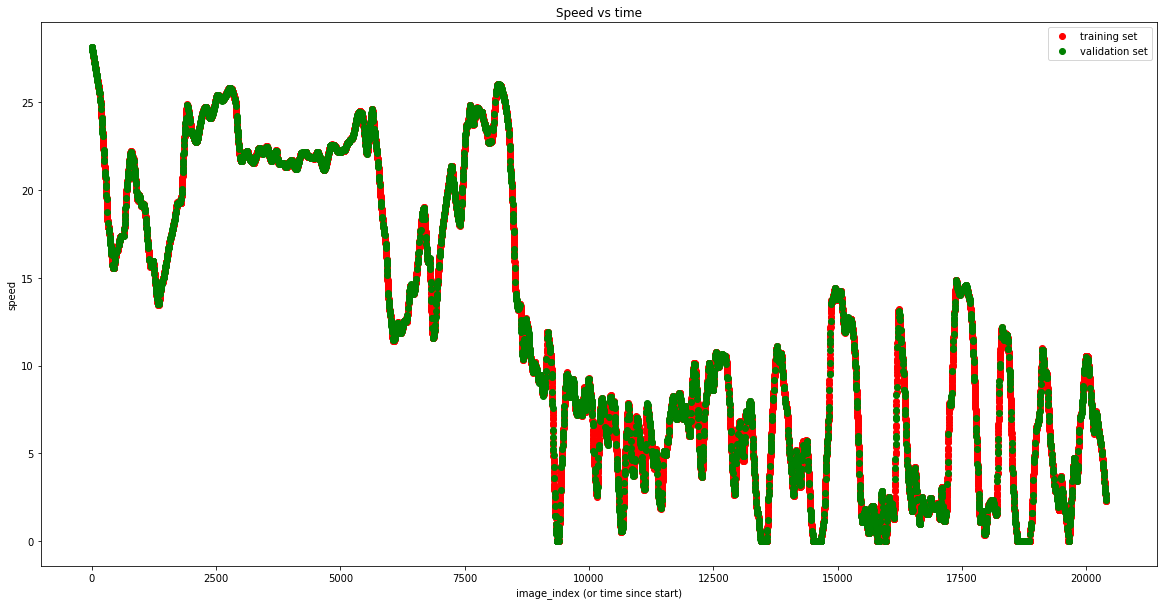

----
valid_data:  (4080, 4)
train_data:  (16319, 4)


In [9]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(train_data.sort_values(['image_index'])[['image_index']], train_data.sort_values(['image_index'])[['speed']], 'ro')
plt.plot(valid_data.sort_values(['image_index'])[['image_index']], valid_data.sort_values(['image_index'])[['speed']], 'go')
plt.xlabel('image_index (or time since start)')
plt.ylabel('speed')
plt.title('Speed vs time')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()
plt.close()

print('----')
print('valid_data: ', valid_data.shape)
print('train_data: ', train_data.shape)

In [10]:
def change_brightness(image, bright_factor):
    """
    Augments the brightness of the image by multiplying the saturation by a uniform random variable
    Input: image (RGB)
    returns: image with brightness augmentation
    """
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # perform brightness augmentation only on the second channel
    hsv_image[:,:,2] = hsv_image[:,:,2] * bright_factor
    
    # change back to RGB
    image_rgb = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    return image_rgb

In [11]:
# img=mpimg.imread(train_meta['image_path'][60])
# print('original image shape:', img.shape)
# plt.imshow(img)
# plt.show()
# plt.close()

# bright_factor = 0.7 + np.random.uniform()
# print('bright_factor:', bright_factor)
# print('brightned image')
# img=mpimg.imread(train_meta['image_path'][60])
# plt.imshow(change_brightness(img, bright_factor))
# plt.show()
# plt.close()

In [12]:
def opticalFlowDense(image_current, image_next):
    """
    input: image_current, image_next (RGB images)
    calculates optical flow magnitude and angle and places it into HSV image
    * Set the saturation to the saturation value of image_next
    * Set the hue to the angles returned from computing the flow params
    * set the value to the magnitude returned from computing the flow params
    * Convert from HSV to RGB and return RGB image with same size as original image
    """
    gray_current = cv2.cvtColor(image_current, cv2.COLOR_RGB2GRAY)
    gray_next = cv2.cvtColor(image_next, cv2.COLOR_RGB2GRAY)
    
    
    hsv = np.zeros((66, 220, 3))
    # set saturation
    hsv[:,:,1] = cv2.cvtColor(image_next, cv2.COLOR_RGB2HSV)[:,:,1]
 
    # Flow Parameters
#     flow_mat = cv2.CV_32FC2
    flow_mat = None
    image_scale = 0.5
    nb_images = 1
    win_size = 15
    nb_iterations = 2
    deg_expansion = 5
    STD = 1.3
    extra = 0

    # obtain dense optical flow paramters
    flow = cv2.calcOpticalFlowFarneback(gray_current, gray_next,  
                                        flow_mat, 
                                        image_scale, 
                                        nb_images, 
                                        win_size, 
                                        nb_iterations, 
                                        deg_expansion, 
                                        STD, 
                                        0)
                                        
        
    # convert from cartesian to polar
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])  
        
    # hue corresponds to direction
    hsv[:,:,0] = ang * (180/ np.pi / 2)
    
    # value corresponds to magnitude
    hsv[:,:,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    
    # convert HSV to float32's
    hsv = np.asarray(hsv, dtype= np.float32)
    rgb_flow = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)

    
    return rgb_flow

In [29]:
def preprocess_image(image):
    """
    preprocesses the image
    
    input: image (480 (y), 640 (x), 3) RGB
    output: image (shape is (220, 66, 3) as RGB)
    
    This stuff is performed on my validation data and my training data
    Process: 
             1) Cropping out black spots
             3) resize to (220, 66, 3) if not done so already from perspective transform
    """
    # Crop out sky (top) (100px) and black right part (-90px)
    #image_cropped = image[100:440, :-90] # -> (380, 550, 3) #v2 for data
    image_cropped = image[25:375, :] #v1 for data
    
    image = cv2.resize(image_cropped, (220, 66), interpolation = cv2.INTER_AREA)
    
    return image


# def preprocess_image_2(image):
#     """
#     preprocesses the image
    
#     input: image (480 (y), 640 (x), 3) RGB
#     output: image (shape is (220, 66, 3) as RGB)
    
#     This stuff is performed on my validation data and my training data
#     Process: 
#              1) Cropping out black spots
#              3) resize to (220, 66, 3) if not done so already from perspective transform
#     """
#     # Crop out sky (top) (100px) and black right part (-90px)
#     image_cropped = image[30:400, :-90] # -> (380, 550, 3)
    
#     image = cv2.resize(image_cropped, (220, 66), interpolation = cv2.INTER_AREA)
    
#     return image

original image shape: (480, 640, 3)


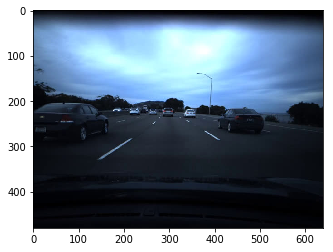

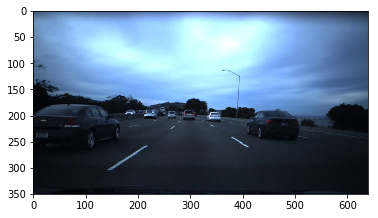

post prosessed image: (66, 220, 3)


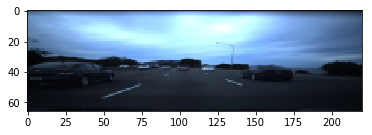

In [30]:
img=mpimg.imread('/'+train_meta['image_path'][2008])
print('original image shape:', img.shape)
plt.imshow(img)
plt.show()
plt.close()

post_img = preprocess_image(img)
print('post prosessed image:', post_img.shape)
plt.imshow(post_img)
plt.show()
plt.close()

In [27]:
def preprocess_image_valid_from_path(image_path, speed):
    img = cv2.imread(image_path)
    plt.imshow(img)
    plt.show()
    plt.close()
    print(img.shape)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    print(img.shape)
    
    plt.imshow(img)
    plt.show()
    plt.close()
    img = preprocess_image(img)
    return img, speed

def preprocess_image_from_path(image_path, speed, bright_factor):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = change_brightness(img, bright_factor)    
    img = preprocess_image(img)
    return img, speed

## Jovsa Data Generate

In [18]:
def generate_training_data(data, batch_size = 32):
    image_batch = np.zeros((batch_size, 66, 220, 3)) # nvidia input params
    label_batch = np.zeros((batch_size))
    while True:
        for i in range(batch_size):
            # generate a random index with a uniform random distribution from 1 to len - 1
            idx = np.random.randint(1, len(data) - 1)
            
            # Generate a random bright factor to apply to both images
            bright_factor = 0.2 + np.random.uniform()
            
            row_now = data.iloc[[idx]].reset_index()
            row_prev = data.iloc[[idx - 1]].reset_index()
            row_next = data.iloc[[idx + 1]].reset_index()
            
            # Find the 3 respective times to determine frame order (current -> next)
            
            time_now = row_now['image_index'].values[0]
            time_prev = row_prev['image_index'].values[0]
            time_next = row_next['image_index'].values[0]
            
            if abs(time_now - time_prev) == 1 and time_now > time_prev:
                row1 = row_prev
                row2 = row_now
                
            elif abs(time_next - time_now) == 1 and time_next > time_now:
                row1 = row_now
                row2 = row_next
            else:
                print('Error generating row-generate training data')            
            
            x1, y1 = preprocess_image_from_path(row1['image_path'].values[0],
                                                row1['speed'].values[0],
                                               bright_factor)
            
            # preprocess another image
            x2, y2 = preprocess_image_from_path(row2['image_path'].values[0], 
                                                row2['speed'].values[0],
                                               bright_factor)
           
            # compute optical flow send in images as RGB
            rgb_diff = opticalFlowDense(x1, x2)
                        
            # calculate mean speed
            y = np.mean([y1, y2])
            
            image_batch[i] = rgb_diff
            label_batch[i] = y
        
        #print('image_batch', image_batch.shape, ' label_batch', label_batch)
        # Shuffle the pairs before they get fed into the network
        yield shuffle(image_batch, label_batch)

## MY DATA GENERATE (iterating through whole data set - not random pick)

In [68]:
def my_generate_training_data(data, batch_size = 32):
    image_batch = np.zeros((batch_size, 66, 220, 3)) # nvidia input params
    label_batch = np.zeros((batch_size))
    idx = 1
    while True:

        for i in range(batch_size):
            if idx > len(data)-2:
                idx = 1
            print(idx)
            # Generate a random bright factor to apply to both image
            bright_factor = 0.2 + np.random.uniform()
            
            row_now = data.iloc[[idx]].reset_index()
            row_prev = data.iloc[[idx - 1]].reset_index()
            row_next = data.iloc[[idx + 1]].reset_index()
            
            # Find the 3 respective times to determine frame order (current -> next)
            
            time_now = row_now['image_index'].values[0]
            time_prev = row_prev['image_index'].values[0]
            time_next = row_next['image_index'].values[0]
            
            if abs(time_now - time_prev) == 1 and time_now > time_prev:
                row1 = row_prev
                row2 = row_now
                
            elif abs(time_next - time_now) == 1 and time_next > time_now:
                row1 = row_now
                row2 = row_next
            else:
                print('Error generating row-generate training data')            
            
            x1, y1 = preprocess_image_from_path('/'+row1['image_path'].values[0],
                                                row1['speed'].values[0],
                                               bright_factor)
            
            # preprocess another image
            x2, y2 = preprocess_image_from_path('/'+row2['image_path'].values[0], 
                                                row2['speed'].values[0],
                                               bright_factor)
           
            
            # compute optical flow send in images as RGB
            rgb_diff = opticalFlowDense(x1, x2)
                        
            # calculate mean speed
            y = np.mean([y1, y2])
            
            image_batch[i] = rgb_diff
            label_batch[i] = y
            

            idx += 2
        
        #print('image_batch', image_batch.shape, ' label_batch', label_batch)
        # Shuffle the pairs before they get fed into the network
        yield shuffle(image_batch, label_batch)

## my generate2

In [17]:
def my2_generate_training_data(data,lookup_df, batch_size = 32):
    image_batch = np.zeros((batch_size, 66, 220, 3)) # nvidia input params
    label_batch = np.zeros((batch_size))
    idx = 0

    while True:
        for i in range(batch_size):
            if idx == len(data): idx=0
            
            id1 = data.index[idx]
            id2 = id1 + 1

            row1 = lookup_df.iloc[[id1]]
            row2 = lookup_df.iloc[[id2]]
            
            
            # Generate a random bright factor to apply to both image
            bright_factor = 0.2 + np.random.uniform()
            
            x1, y1 = preprocess_image_from_path('/'+row1['image_path'].values[0],
                                                row1['speed'].values[0],
                                               bright_factor)
            
            # preprocess another image
            x2, y2 = preprocess_image_from_path('/'+row2['image_path'].values[0], 
                                                row2['speed'].values[0],
                                               bright_factor)
           
            # compute optical flow send in images as RGB
            rgb_diff = opticalFlowDense(x1, x2)
                        
            # calculate mean speed
            y = np.mean([y1, y2])
            
            image_batch[i] = rgb_diff
            label_batch[i] = y
            
            idx += 1
        
        #print('image_batch', image_batch.shape, ' label_batch', label_batch)
        # Shuffle the pairs before they get fed into the network
        yield shuffle(image_batch, label_batch)

In [18]:
print("goodbye blue sky")

goodbye blue sky


In [20]:
def generate_validation_data(data):
    print("hoooop")
    while True:
        for idx in range(1, len(data) - 1): # start from the second row because we may try to grab it and need its prev to be in bounds
            row_now = data.iloc[[idx]].reset_index()
            row_prev = data.iloc[[idx - 1]].reset_index()
            row_next = data.iloc[[idx + 1]].reset_index()
            
            # Find the 3 respective times to determine frame order (current -> next)
            
            time_now = row_now['image_index'].values[0]
            time_prev = row_prev['image_index'].values[0]
            time_next = row_next['image_index'].values[0]
            
            if abs(time_now - time_prev) == 1 and time_now > time_prev:
                row1 = row_prev
                row2 = row_now
                
            elif abs(time_next - time_now) == 1 and time_next > time_now:
                row1 = row_now
                row2 = row_next
            else:
                print('Error generating row-generate validation data')        
            
            x1, y1 = preprocess_image_valid_from_path(row1['image_path'].values[0], row1['speed'].values[0])
            x2, y2 = preprocess_image_valid_from_path(row2['image_path'].values[0], row2['speed'].values[0])
            
            img_diff = opticalFlowDense(x1, x2)
            img_diff = img_diff.reshape(1, img_diff.shape[0], img_diff.shape[1], img_diff.shape[2])
            y = np.mean([y1, y2])
            
            speed = np.array([[y]])
            
            #print('img_diff', img_diff.shape, ' speed', speed)
            yield img_diff, speed

In [21]:
N_img_height = 66
N_img_width = 220
N_img_channels = 3
def nvidia_model():
    inputShape = (N_img_height, N_img_width, N_img_channels)

    model = Sequential()
    # normalization    
    # perform custom normalization before lambda layer in network
    model.add(Lambda(lambda x: x/ 127.5 - 1, input_shape = inputShape))

    model.add(Convolution2D(24, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv1'))
    
    
    model.add(ELU())    
    model.add(Convolution2D(36, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv2'))
    
    model.add(ELU())    
    model.add(Convolution2D(48, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv3'))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Convolution2D(64, (3, 3), 
                            strides = (1,1), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv4'))
    
    model.add(ELU())              
    model.add(Convolution2D(64, (3, 3), 
                            strides= (1,1), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv5'))
              
              
    model.add(Flatten(name = 'flatten'))
    model.add(ELU())
    model.add(Dense(100, kernel_initializer = 'he_normal', name = 'fc1'))
    model.add(ELU())
    model.add(Dense(50, kernel_initializer = 'he_normal', name = 'fc2'))
    model.add(ELU())
    model.add(Dense(10, kernel_initializer = 'he_normal', name = 'fc3'))
    model.add(ELU())
    
    # do not put activation at the end because we want to exact output, not a class identifier
    model.add(Dense(1, name = 'output', kernel_initializer = 'he_normal'))
    
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer = adam, loss = 'mse')

    return model

In [22]:
if not os.path.exists(assets_filepath):
    os.makedirs(assets_filepath)

In [26]:
valid_generator = generate_validation_data(valid_data)
valid_generator = my2_generate_training_data(valid_data,lookup_df,batch_size=1)

val_size = len(valid_data.index)

earlyStopping = EarlyStopping(monitor='val_loss', 
                              patience=1, 
                              verbose=1, 
                              min_delta = 0.23,
                              mode='min',)

modelCheckpoint = ModelCheckpoint(weights_loc, 
                                  monitor = 'val_loss', 
                                  save_best_only = True, 
                                  mode = 'min', 
                                  verbose = 1,
                                 save_weights_only = True)

tensorboard = TensorBoard(log_dir=tensorboard_loc, histogram_freq=0,
                            write_graph=True, write_images=True)

callbacks_list = [modelCheckpoint, tensorboard, earlyStopping]
#callbacks_list = [ CustomCallback()]


In [34]:
model = nvidia_model()
#model.summary()
#dir(model)

In [28]:
train_size = len(train_data.index)
train_generator = my2_generate_training_data(train_data,lookup_df, batch_size)
#train_generator = generate_training_data(train_data, batch_size)
history = model.fit_generator(
        train_generator, 
        steps_per_epoch = steps_per_epoch, 
        epochs = num_epochs,
        callbacks = callbacks_list,
        verbose = 1,
        validation_data = valid_generator,
        validation_steps = val_size)

print(history)

Epoch 1/25
800/800 [==============================] - 274s - loss: 39.6499 - val_loss: 20.7081
Epoch 2/25
800/800 [==============================] - 274s - loss: 20.1681 - val_loss: 16.1344
Epoch 3/25
 76/800 [=>............................] - ETA: 167s - loss: 16.7762

KeyboardInterrupt: 

In [ ]:
# saving history
pickle.dump(history.history, open(history_loc, "wb"))

# Post Analysis

In [26]:
# model processing hyperparameters
batch_size = 16
num_epochs = 25 #100 #90 
steps_per_epoch = 800

# run specific constants
model_name = 'nvidia' #nvidia2
run_name = 'model={}-batch_size={}-num_epoch={}-steps_per_epoch={}'.format(model_name,
                                                                          batch_size,
                                                                          num_epochs,
                                                                          steps_per_epoch)

In [27]:
history = pickle.load(open(history_loc, "rb" ))
model.load_weights(weights_loc)
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer = adam, loss = 'mse')

In [28]:
val_score = model.evaluate_generator(valid_generator, steps=val_size)
print('val score:', val_score)

val score: 4.07124506622


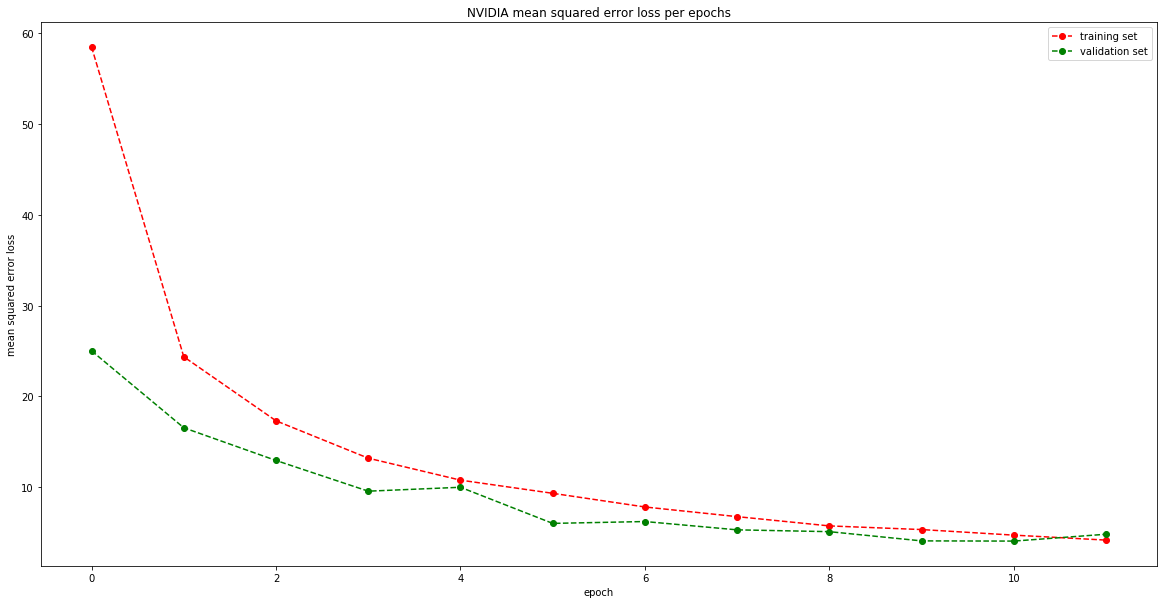

In [29]:
### plot the training and validation loss for each epoch
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(history['loss'], 'ro--')
plt.plot(history['val_loss'], 'go--')
plt.title('NVIDIA mean squared error loss per epochs')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()
plt.close()

In [30]:
def make_predictions(data):
    for idx in tqdm(range(1, len(data.index)-1)):
        row_now = data.iloc[[idx]].reset_index()
        row_prev = data.iloc[[idx - 1]].reset_index()
        row_next = data.iloc[[idx + 1]].reset_index()
        
        time_now = row_now['image_index'].values[0]
        time_prev = row_prev['image_index'].values[0]
        time_next = row_next['image_index'].values[0]
        
        if abs(time_now - time_prev) == 1 and time_now > time_prev:
            row1 = row_prev
            row2 = row_now
        elif abs(time_next - time_now) == 1 and time_next > time_now:
            row1 = row_now
            row2 = row_next
        else:
            print('Error generating row')
        
        x1, y1 = preprocess_image_valid_from_path(row1['image_path'].values[0], row1['speed'].values[0])
        x2, y2 = preprocess_image_valid_from_path(row2['image_path'].values[0], row2['speed'].values[0])
        
        img_diff = opticalFlowDense(x1, x2)
        img_diff = img_diff.reshape(1, img_diff.shape[0], img_diff.shape[1], img_diff.shape[2])
        y = np.mean([y1, y2])

        prediction = model.predict(img_diff)
        error = abs(prediction-y2)
        
        #print(prediction, error, time_now)
        data.loc[data['image_index']==time_now, 'predicted_speed'] = prediction[0][0]
        data.loc[data['image_index']==time_now, 'error'] = error[0][0]

In [31]:
make_predictions(valid_data)

100%|██████████| 8158/8158 [02:52<00:00, 47.34it/s]


In [32]:
print(mean_squared_error(valid_data.iloc[1:-1, 3], 
                         valid_data.iloc[1:-1, 4]))

3.96345559192


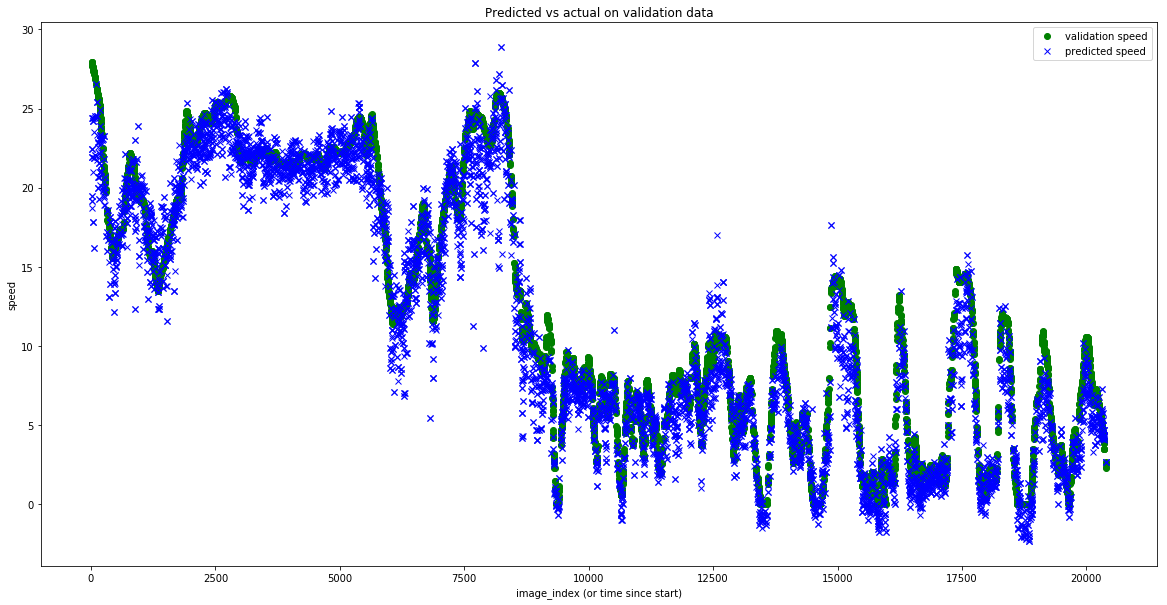

In [33]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(valid_data.sort_values(['image_index'])[['image_index']], 
         valid_data.sort_values(['image_index'])[['speed']], 'go')
plt.plot(valid_data.sort_values(['image_index'])[['image_index']], 
         valid_data.sort_values(['image_index'])[['predicted_speed']], 'bx')
plt.xlabel('image_index (or time since start)')
plt.ylabel('speed')
plt.title('Predicted vs actual on validation data')
plt.legend(['validation speed', 'predicted speed'], loc='upper right')
plt.show()
plt.close()

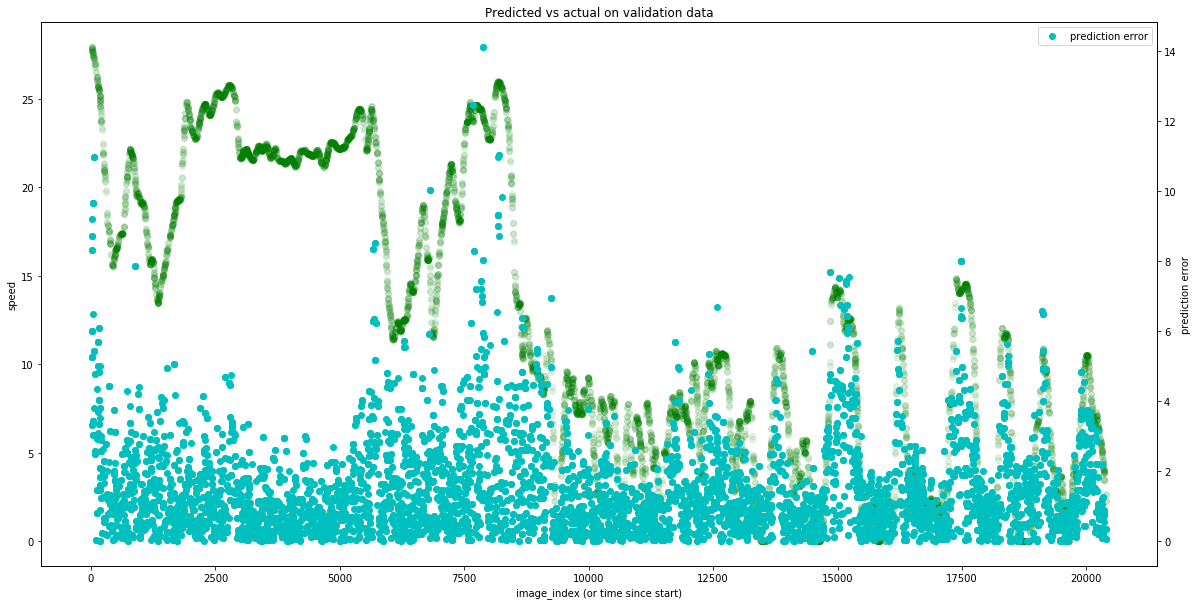

In [34]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.plot(valid_data.sort_values(['image_index'])[['image_index']], 
         valid_data.sort_values(['image_index'])[['speed']], 'go', alpha=0.1)

ax2 = ax1.twinx()
ax2.plot(valid_data.sort_values(['image_index'])[['image_index']], 
         valid_data.sort_values(['image_index'])[['error']], 'co')

ax1.set_xlabel('image_index (or time since start)')
ax1.set_ylabel('speed')
ax2.set_ylabel('prediction error')
plt.title('Predicted vs actual on validation data')
plt.legend(['prediction error'], loc='upper right')
plt.show()
plt.close()

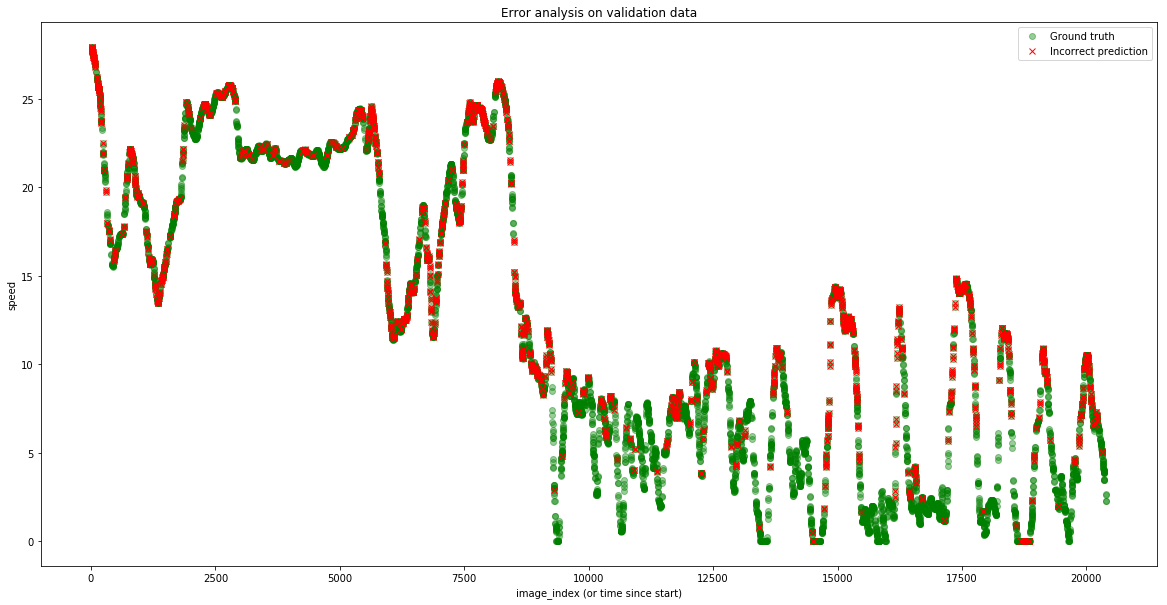

<function __main__.error_analysis>

In [35]:
def error_analysis(error_thresh):
    fig, ax = plt.subplots(figsize=(20,10))
    ax.plot(valid_data.sort_values(['image_index'])[['image_index']], 
             valid_data.sort_values(['image_index'])[['speed']], 'go', alpha=0.4)


    ax.plot(valid_data[valid_data['error']>error_thresh].sort_values(['image_index'])[['image_index']], 
             valid_data[valid_data['error']>error_thresh].sort_values(['image_index'])[['speed']], 'rx')


    ax.set_xlabel('image_index (or time since start)')
    ax.set_ylabel('speed')
    plt.title('Error analysis on validation data')
    plt.legend(['Ground truth', 'Incorrect prediction'], loc='upper right')
    plt.show()

interact(error_analysis, error_thresh=(0,5, 0.1))

## Predicting on Test

In [36]:
test_meta = pd.read_csv(os.path.join(CLEAN_DATA_PATH, 'test_meta.csv'))
assert(test_meta.shape[0] == test_frames)
assert(test_meta.shape[1] == 3)
print('shape: ', test_meta.shape)

shape:  (10798, 3)


In [37]:
make_predictions(test_meta)

100%|██████████| 10796/10796 [03:48<00:00, 47.31it/s]


In [38]:
window_size = 25
test_meta['smooth_predicted_speed'] = pd.rolling_median(test_meta['predicted_speed'], window_size, center=True)
test_meta['smooth_error'] = test_meta.apply(lambda x: x['smooth_predicted_speed'] - x['speed'], axis=1)

test_meta['smooth_predicted_speed'] = test_meta.apply(lambda x: 
                                                        x['predicted_speed'] if np.isnan(x['smooth_predicted_speed'])
                                                       else x['smooth_predicted_speed'],axis=1)

test_meta['smooth_error'] = test_meta.apply(lambda x: x['error'] if np.isnan(x['smooth_error'])
                                                       else x['smooth_error'],axis=1)


/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_median is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=True,window=25).median()
  


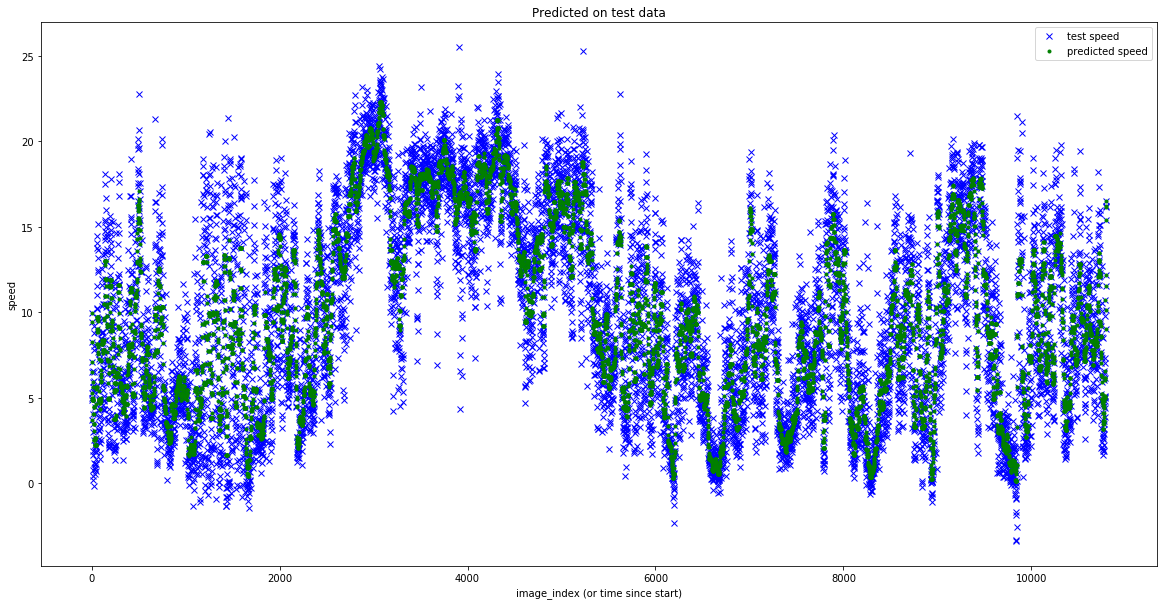

In [39]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(test_meta.sort_values(['image_index'])[['image_index']], 
         test_meta.sort_values(['image_index'])[['predicted_speed']], 'bx')
plt.plot(test_meta.sort_values(['image_index'])[['image_index']], 
         test_meta.sort_values(['image_index'])[['smooth_predicted_speed']], 'g.')
plt.xlabel('image_index (or time since start)')
plt.ylabel('speed')
plt.title('Predicted on test data')
plt.legend(['test speed', 'predicted speed'], loc='upper right')
plt.show()
plt.close()

In [40]:
output_file = test_meta['smooth_predicted_speed']
output_file.to_csv(os.path.join(ASSETS_PATH, 'test.txt'), index=False)

In [41]:
output_file.head()

0         NaN
1    6.536335
2    9.430263
3    9.962568
4    7.101459
Name: smooth_predicted_speed, dtype: float64

## Prediction on Train

In [42]:
make_predictions(train_meta)

100%|██████████| 20398/20398 [07:13<00:00, 47.02it/s]


In [43]:
train_meta.head()

,image_path,image_index,speed,predicted_speed,error
0,/speed_challenge_2017/clean_data/train_imgs/0.jpg,0,28.105569,NaN,NaN
1,/speed_challenge_2017/clean_data/train_imgs/1.jpg,1,28.105569,20.832930,7.272640
2,/speed_challenge_2017/clean_data/train_imgs/2.jpg,2,28.106527,21.204763,6.901764
3,/speed_challenge_2017/clean_data/train_imgs/3.jpg,3,28.130404,20.119366,8.011038
4,/speed_challenge_2017/clean_data/train_imgs/4.jpg,4,28.109243,23.149778,4.959465


In [44]:
window_size = 25
train_meta['smooth_predicted_speed'] = pd.rolling_median(train_meta['predicted_speed'], window_size, center=True)
train_meta['smooth_error'] = train_meta.apply(lambda x: x['smooth_predicted_speed'] - x['speed'], axis=1)

train_meta['smooth_predicted_speed'] = train_meta.apply(lambda x: 
                                                        x['predicted_speed'] if np.isnan(x['smooth_predicted_speed'])
                                                       else x['smooth_predicted_speed'],axis=1)

train_meta['smooth_error'] = train_meta.apply(lambda x: x['error'] if np.isnan(x['smooth_error'])
                                                       else x['smooth_error'],axis=1)

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_median is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=True,window=25).median()
  


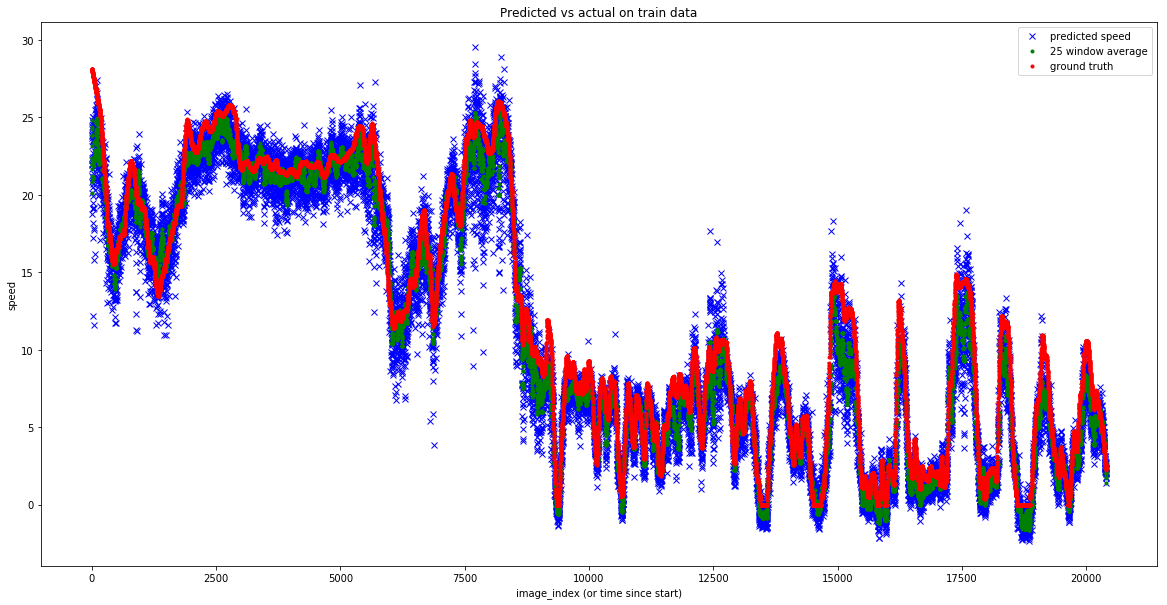

In [45]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(train_meta.sort_values(['image_index'])[['image_index']], 
         train_meta.sort_values(['image_index'])[['predicted_speed']], 'bx')
plt.plot(train_meta.sort_values(['image_index'])[['image_index']], 
         train_meta.sort_values(['image_index'])[['smooth_predicted_speed']], 'g.')
plt.plot(train_meta.sort_values(['image_index'])[['image_index']], 
         train_meta.sort_values(['image_index'])[['speed']], 'r.')
plt.xlabel('image_index (or time since start)')
plt.ylabel('speed')
plt.title('Predicted vs actual on train data')
plt.legend(['predicted speed', (str(window_size) +' window average'), 'ground truth'], loc='upper right')
plt.show()
plt.close()

In [46]:
print(mean_squared_error(train_meta.iloc[1:-1, 2], 
                         train_meta.iloc[1:-1, 5]))

2.22581241328


## Saving Results

In [47]:
print("hello")

hello


In [48]:
train_meta.head()

,image_path,image_index,speed,predicted_speed,error,smooth_predicted_speed,smooth_error
0,/speed_challenge_2017/clean_data/train_imgs/0.jpg,0,28.105569,NaN,NaN,NaN,NaN
1,/speed_challenge_2017/clean_data/train_imgs/1.jpg,1,28.105569,20.832930,7.272640,20.832930,7.272640
2,/speed_challenge_2017/clean_data/train_imgs/2.jpg,2,28.106527,21.204763,6.901764,21.204763,6.901764
3,/speed_challenge_2017/clean_data/train_imgs/3.jpg,3,28.130404,20.119366,8.011038,20.119366,8.011038
4,/speed_challenge_2017/clean_data/train_imgs/4.jpg,4,28.109243,23.149778,4.959465,23.149778,4.959465


In [49]:
output_file.head()

0         NaN
1    6.536335
2    9.430263
3    9.962568
4    7.101459
Name: smooth_predicted_speed, dtype: float64

In [51]:
len(output_file)

10798

In [50]:
print("ola2")

ola2
